<a href="https://colab.research.google.com/github/Josephmdlv/Final-work/blob/main/HypoTest_Multi_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import numpy as np
import requests
import os

def download_and_process_data(url):
  filename = os.path.basename(url)
  response = requests.get(url)

  with open(filename, 'wb') as file:
      file.write(response.content)

  df = pd.read_csv(filename)

  return df


df = download_and_process_data("https://raw.githubusercontent.com/IkerZha0401/QM2_Final_PJ/refs/heads/main/ProtestV1.csv")
df


,event_id_cnty,event_date,year,country,latitude,longitude
0,IRN6075,31 January 2020,2020,Iran,32.6525,51.6746
1,ALG8120,31 January 2020,2020,Algeria,36.7500,5.0833
2,ALG8123,31 January 2020,2020,Algeria,36.3800,3.9014
3,ALG8124,31 January 2020,2020,Algeria,36.7664,3.4772
4,ALG8126,31 January 2020,2020,Algeria,36.3650,6.6147
...,...,...,...,...,...,...
52680,ALG1318,25 January 2005,2005,Algeria,35.3758,1.3131
52681,ALG1316,25 January 2005,2005,Algeria,34.8472,-1.7286
52682,ALG1317,25 January 2005,2005,Algeria,36.4703,1.4531
52683,ALG1314,25 January 2005,2005,Algeria,36.0750,4.7750


data cleaning and dataset merging

In [13]:
df.drop_duplicates(subset=['event_id_cnty'], inplace=True)
df['year']=df['year'].astype(int)
grouped_df = df.groupby(['country','year']).size().reset_index(name='annual_protest_count')
grouped_df.sort_values(by=['country','year'], inplace=True)
print(grouped_df.head(20))
grouped_df.to_csv('protest_annual_data.csv', index=False)

    country  year  annual_protest_count
0   Algeria  2005                     6
1   Algeria  2006                     7
2   Algeria  2007                     2
3   Algeria  2008                     9
4   Algeria  2009                    12
5   Algeria  2010                     8
6   Algeria  2011                    90
7   Algeria  2012                    60
8   Algeria  2013                   103
9   Algeria  2014                   126
10  Algeria  2015                   240
11  Algeria  2016                   233
12  Algeria  2017                   360
13  Algeria  2018                   510
14  Algeria  2019                  2079
15  Algeria  2020                   201
16  Bahrain  2016                  2036
17  Bahrain  2017                  2387
18  Bahrain  2018                   877
19  Bahrain  2019                   365


In [14]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/MENA_Corruption_Rates.csv")
df

,Country Name,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Algeria,26,27,28,31,30,32,28,29,29,34,36,36,36,34,33,35,34,34
1,Bahrain,61,58,58,57,50,54,51,49,51,51,48,49,51,43,43,36,43,43
2,Egypt,33,32,34,33,29,28,28,31,29,32,32,37,36,34,32,35,34,34
3,"Iran, Islamic Rep.",30,29,29,27,25,23,18,22,27,28,25,27,27,29,29,28,29,29
4,Iraq,22,21,22,19,15,13,15,15,18,18,16,16,16,17,17,18,17,17
5,Israel,70,64,63,59,61,60,61,61,58,60,61,60,61,64,62,61,64,64
6,Jordan,46,53,57,53,47,51,50,47,45,48,45,49,53,48,48,49,48,48
7,Kuwait,53,46,47,48,43,43,41,45,46,44,43,44,49,41,39,41,41,41
8,Lebanon,30,27,31,36,30,30,25,25,25,30,28,27,28,28,28,28,28,28
9,Libya,21,25,25,27,25,26,25,22,20,21,15,18,16,14,14,17,14,14


In [15]:
df_corruption_long = df.melt(
    id_vars='Country Name',
    var_name='year',
    value_name='corruption_rate'
)

df_corruption_long.rename(columns={'Country Name':'country'},inplace=True)
df_corruption_long['year']=df_corruption_long['year'].astype(int)


import re

df_corruption_long['country'] = df_corruption_long['country'].str.replace(
    r'^Iran, Islamic Rep.*$', 'Iran', regex=True
)
df_corruption_long['country'] = df_corruption_long['country'].str.replace(
    r'^Yemen, Rep.*$', 'Yemen', regex=True
)
df_corruption_long['country'] = df_corruption_long['country'].str.replace(
    r'^Syrian Arab Republic.*$', 'Syria', regex=True
)
df_corruption_long.head()

,country,year,corruption_rate
0,Algeria,2003,26
1,Bahrain,2003,61
2,Egypt,2003,33
3,Iran,2003,30
4,Iraq,2003,22


In [16]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/MENA_Unemployment_Rates.csv")
df


,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United Arab Emirates,2.250,2.442,2.657,2.902,2.964,3.120,2.959,2.925,2.805,...,2.568,2.266,2.074,1.962,1.792,1.640,2.462,2.236,2.331,4.294
1,Bahrain,1.138,1.171,1.184,1.165,1.094,1.044,1.039,1.019,1.024,...,1.209,1.200,1.182,1.146,1.166,1.195,1.196,1.202,1.226,1.767
2,Djibouti,26.862,26.780,26.761,26.647,26.602,26.605,26.528,26.423,26.299,...,26.399,26.252,26.211,26.217,26.095,25.999,26.064,26.180,26.246,27.645
3,Algeria,29.770,27.300,25.900,23.720,17.650,15.270,12.270,13.790,11.330,...,9.960,10.970,9.820,10.207,11.206,10.202,12.000,12.150,12.285,14.040
4,"Egypt, Arab Rep.",8.980,9.260,10.010,10.910,10.320,11.049,10.490,8.800,8.517,...,11.849,12.597,13.154,13.105,13.052,12.450,11.767,9.855,7.851,7.974
5,"Iran, Islamic Rep.",11.699,12.356,12.800,11.528,10.300,11.813,11.519,10.772,10.630,...,12.491,12.275,10.595,10.680,11.166,12.618,12.232,12.195,10.740,9.687
6,Iraq,8.095,8.288,8.636,8.965,8.736,8.596,8.434,8.646,8.467,...,8.186,7.965,9.208,10.590,10.838,10.820,13.020,13.509,14.142,15.776
7,Israel,11.102,11.812,12.888,13.505,13.029,11.342,10.707,9.379,7.704,...,7.139,6.762,6.137,5.789,5.176,4.723,4.140,3.917,3.731,4.169
8,Jordan,13.700,14.700,15.300,14.500,14.619,14.800,14.000,13.100,12.700,...,12.900,12.200,12.600,11.900,13.075,15.275,18.120,18.257,16.801,19.213
9,Kuwait,0.800,0.800,1.100,1.300,1.700,1.457,1.300,1.500,1.750,...,2.056,2.234,2.476,2.900,2.200,2.160,2.223,2.198,2.239,3.535


In [17]:
df_unemployment = df.melt(
    id_vars='Country Name',
    var_name='year',
    value_name='unemployment rate'
)

df_unemployment.rename(columns={'Country Name':'country'},inplace=True)
df_unemployment['year']=df_corruption_long['year'].astype(int)

countries = df_unemployment['country'].unique()
print(countries)
df_unemployment['country'] = df_unemployment['country'].str.replace(
    r'^Iran, Islamic Rep.*$', 'Iran', regex=True
)
df_unemployment['country'] = df_unemployment['country'].str.replace(
    r'^Yemen, Rep.*$', 'Yemen', regex=True
)
df_unemployment['country'] = df_unemployment['country'].str.replace(
    r'^Syrian Arab Republic.*$', 'Syria', regex=True
)
df_unemployment['country'] = df_unemployment['country'].str.replace(
    r'^Egypt, Arab Rep.*$', 'Egypt', regex=True
)
df_unemployment.head()


['United Arab Emirates' 'Bahrain' 'Djibouti' 'Algeria' 'Egypt, Arab Rep.'
 'Iran, Islamic Rep.' 'Iraq' 'Israel' 'Jordan' 'Kuwait' 'Lebanon' 'Libya'
 'Morocco' 'Oman' 'Qatar' 'Saudi Arabia' 'Sudan' 'Somalia'
 'Syrian Arab Republic' 'Tunisia' 'Yemen, Rep.']


,country,year,unemployment rate
0,United Arab Emirates,2003.0,2.250
1,Bahrain,2003.0,1.138
2,Djibouti,2003.0,26.862
3,Algeria,2003.0,29.770
4,Egypt,2003.0,8.980


In [18]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/MENA_HDI.csv")
df

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Algeria,0.652,0.659,0.668,0.675,0.683,0.690,0.696,0.701,0.709,...,0.725,0.726,0.729,0.732,0.736,0.738,0.738,0.740,0.742,0.730
1,Bahrain,0.775,0.786,0.792,0.799,0.795,0.791,0.794,0.800,0.803,...,0.812,0.827,0.839,0.839,0.859,0.862,0.867,0.880,0.888,0.884
2,Djibouti,0.330,0.340,0.346,0.357,0.365,0.374,0.384,0.394,0.401,...,0.432,0.444,0.453,0.463,0.473,0.482,0.491,0.499,0.508,0.512
3,Egypt,0.629,0.633,0.634,0.632,0.635,0.637,0.642,0.649,0.656,...,0.671,0.679,0.684,0.688,0.695,0.702,0.709,0.717,0.724,0.729
4,Iran (Islamic Republic of),0.692,0.700,0.708,0.713,0.722,0.727,0.738,0.742,0.744,...,0.765,0.780,0.780,0.783,0.782,0.785,0.788,0.787,0.785,0.779
5,Iraq,0.583,0.588,0.588,0.566,0.588,0.591,0.591,0.596,0.612,...,0.637,0.644,0.648,0.651,0.656,0.661,0.667,0.673,0.678,0.661
6,Israel,0.835,0.838,0.843,0.843,0.847,0.856,0.864,0.876,0.877,...,0.890,0.891,0.896,0.899,0.899,0.902,0.906,0.908,0.909,0.906
7,Jordan,0.681,0.687,0.691,0.697,0.707,0.713,0.719,0.716,0.726,...,0.730,0.736,0.738,0.737,0.738,0.740,0.744,0.742,0.744,0.740
8,Kuwait,0.780,0.779,0.785,0.796,0.800,0.800,0.800,0.802,0.806,...,0.817,0.821,0.813,0.816,0.829,0.832,0.835,0.836,0.838,0.826
9,Lebanon,NaN,NaN,NaN,NaN,NaN,0.710,0.711,0.724,0.733,...,0.755,0.757,0.756,0.755,0.756,0.760,0.765,0.764,0.760,0.742


In [19]:
df_HDI = df.melt(
    id_vars='Country Name',
    var_name='year',
    value_name='HDI'
)

df_HDI.rename(columns={'Country Name':'country'},inplace=True)
df_HDI['year']=df_corruption_long['year'].astype(int)

df_HDI = df.melt(
    id_vars='Country Name',
    var_name='year',
    value_name='HDI'
)

df_HDI.rename(columns={'Country Name':'country'},inplace=True)
df_HDI['year']=df_HDI['year'].astype(int)

countries1 = df_HDI['country'].unique()
print(countries1)
df_HDI['country'] = df_HDI['country'].replace({
    'Iran (Islamic Republic of)': 'Iran',
    'Syrian Arab Republic': 'Syria',
})

df_HDI.head()
df_HDI = df.melt(
    id_vars='Country Name',
    var_name='year',
    value_name='HDI'
)

df_HDI.rename(columns={'Country Name':'country'},inplace=True)
df_HDI['year']=df_HDI['year'].astype(int)

countries1 = df_HDI['country'].unique()
print(countries1)
df_HDI['country'] = df_HDI['country'].replace({
    'Iran (Islamic Republic of)': 'Iran',
    'Syrian Arab Republic': 'Syria',
})

df_HDI.head()

['Algeria' 'Bahrain' 'Djibouti' 'Egypt' 'Iran (Islamic Republic of)'
 'Iraq' 'Israel' 'Jordan' 'Kuwait' 'Lebanon' 'Libya' 'Morocco' 'Oman'
 'Qatar' 'Saudi Arabia' 'Sudan' 'Syrian Arab Republic' 'Tunisia'
 'United Arab Emirates' 'Yemen']
['Algeria' 'Bahrain' 'Djibouti' 'Egypt' 'Iran (Islamic Republic of)'
 'Iraq' 'Israel' 'Jordan' 'Kuwait' 'Lebanon' 'Libya' 'Morocco' 'Oman'
 'Qatar' 'Saudi Arabia' 'Sudan' 'Syrian Arab Republic' 'Tunisia'
 'United Arab Emirates' 'Yemen']


,country,year,HDI
0,Algeria,2000,0.652
1,Bahrain,2000,0.775
2,Djibouti,2000,0.330
3,Egypt,2000,0.629
4,Iran,2000,0.692


In [20]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/MENA_FDI.csv")
df

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,United Arab Emirates,4.236671e+08,2.137013e+08,4.411164e+08,9.911504e+08,2.208000e+09,3.750300e+09,1.089176e+10,1.456773e+10,1.582030e+10,...,2.178000e+09,2.536011e+09,8.828338e+09,1.173590e+10,1.669160e+10,1.571140e+10,1.405995e+10,1.507929e+10,2.122616e+10,1.893733e+10
1,Bahrain,3.635623e+08,8.035886e+07,2.169869e+08,5.167003e+08,8.653081e+08,1.048601e+09,2.914660e+09,1.756313e+09,1.793998e+09,...,7.808511e+08,1.544681e+09,3.727713e+09,1.518617e+09,6.489362e+07,2.433511e+08,1.426064e+09,1.654255e+09,9.417553e+08,1.021277e+09
2,Djibouti,3.286049e+06,3.392959e+06,3.432346e+06,1.422454e+07,3.854356e+07,2.220334e+07,1.082877e+08,1.953511e+08,2.276546e+08,...,7.900023e+07,1.099983e+08,2.860045e+08,1.529982e+08,1.438322e+08,1.599980e+08,1.649299e+08,1.700000e+08,1.749990e+08,1.582300e+08
3,Algeria,1.370000e+07,9.300000e+06,9.857000e+07,2.832063e+07,2.454498e+08,1.156000e+09,1.841000e+09,1.686737e+09,2.638607e+09,...,2.571237e+09,1.500402e+09,1.691887e+09,1.502206e+09,-5.377929e+08,1.638264e+09,1.230243e+09,1.466116e+09,1.381200e+09,1.143918e+09
4,"Egypt, Arab Rep.",1.235000e+09,5.099000e+08,6.469000e+08,2.374000e+08,1.253300e+09,5.375600e+09,1.004280e+10,1.157810e+10,9.494600e+09,...,-4.827000e+08,2.797700e+09,4.192200e+09,4.612200e+09,6.925200e+09,8.106800e+09,7.408700e+09,8.141300e+09,9.010100e+09,5.851800e+09
5,"Iran, Islamic Rep.",3.900000e+07,5.000000e+07,1.520100e+07,-3.257060e+08,1.045730e+08,4.145640e+08,1.484450e+08,3.585710e+08,2.021520e+08,...,2.576280e+08,1.356030e+09,1.892040e+08,3.442000e+06,1.196910e+08,1.041123e+08,7.574844e+07,7.460111e+07,8.482063e+07,7.839006e+07
6,Iraq,NaN,NaN,NaN,NaN,NaN,5.153000e+08,3.830000e+08,9.718000e+08,1.855700e+09,...,2.082000e+09,3.400000e+09,-2.335300e+09,-1.017640e+10,-7.574200e+09,-6.255900e+09,-5.032400e+09,-4.885100e+09,-3.075600e+09,-2.859100e+09
7,Israel,8.047500e+09,1.771300e+09,1.582500e+09,3.322000e+09,2.946900e+09,4.818400e+09,1.439550e+10,8.798100e+09,1.027420e+10,...,8.653000e+09,9.017300e+09,1.184220e+10,6.048900e+09,1.133620e+10,1.198800e+10,1.689250e+10,2.151450e+10,1.736250e+10,2.096870e+10
8,Jordan,9.132581e+08,2.736282e+08,2.382229e+08,5.469676e+08,9.368124e+08,1.984485e+09,3.544006e+09,2.622145e+09,2.826744e+09,...,1.486056e+09,1.548451e+09,1.946597e+09,2.178451e+09,1.600282e+09,1.552958e+09,2.029718e+09,9.549296e+08,7.297183e+08,7.602817e+08
9,Kuwait,1.629983e+07,-1.115163e+08,3.619442e+06,-6.711150e+07,2.375297e+07,2.339041e+08,1.213056e+08,1.115357e+08,-5.951753e+06,...,3.259068e+09,2.872589e+09,1.433630e+09,4.858067e+08,2.846476e+08,2.920265e+08,1.130121e+08,-2.137757e+07,5.156176e+08,-5.580555e+08


In [21]:
df_FDI = df.melt(
    id_vars='Country Name',
    var_name='year',
    value_name='FDI'
)

df_FDI.rename(columns={'Country Name':'country'},inplace=True)
df_FDI['year']=df_corruption_long['year'].astype(int)

countries2 = df_FDI['country'].unique()
print(countries2)
df_HDI['country'] = df_HDI['country'].replace({
    'Iran, Islamic Rep.': 'Iran',
    'Syrian Arab Republic': 'Syria',
    'Yemen, Rep.': 'Yemen'
})

df_HDI.head()


['United Arab Emirates' 'Bahrain' 'Djibouti' 'Algeria' 'Egypt, Arab Rep.'
 'Iran, Islamic Rep.' 'Iraq' 'Israel' 'Jordan' 'Kuwait' 'Lebanon' 'Libya'
 'Morocco' 'Oman' 'Qatar' 'Saudi Arabia' 'Sudan' 'Somalia'
 'Syrian Arab Republic' 'Tunisia' 'Yemen, Rep.']


,country,year,HDI
0,Algeria,2000,0.652
1,Bahrain,2000,0.775
2,Djibouti,2000,0.330
3,Egypt,2000,0.629
4,Iran,2000,0.692


In [22]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/MENA_Countries_GDP_Per_Capita_in_USD.csv")
df

,Year,Algeria,Bahrain,Egypt,Iran,Iraq,Israel,Jordan,Kuwait,Lebanon,Libya,Morocco,Oman,Qatar,Saudi Arabia,Palestine,Syria,Tunisia,United Arab Emirates,Yemen
0,2000,11.07,17.11,7.81,-5.31,26.83,9.56,1.65,21.50,-2.37,4.38,-8.28,23.41,36.06,14.26,-1.56,16.32,-7.40,16.85,23.21
1,2001,6.96,-3.51,-5.13,13.81,-27.54,-3.33,3.89,-10.14,0.66,-12.91,0.54,-1.56,-6.03,-5.21,-9.53,4.18,1.71,-6.11,-0.94
2,2002,2.15,4.30,-13.76,0.40,-11.85,-8.96,4.49,6.33,7.11,-41.39,6.01,2.30,5.09,0.52,-13.43,-0.46,3.84,1.05,5.67
3,2003,17.85,11.00,-7.65,18.27,-35.43,3.11,4.02,22.30,3.51,25.06,21.73,6.17,15.80,11.23,8.78,2.92,17.48,7.89,7.26
4,2004,23.33,10.88,-3.85,21.79,62.37,4.74,9.17,21.16,3.75,22.89,12.48,12.74,29.75,17.31,13.08,11.93,12.50,13.53,14.65
5,2005,14.89,12.21,11.50,17.25,32.67,3.24,7.48,30.95,0.10,39.23,2.74,23.20,28.62,23.12,8.54,11.94,2.53,13.97,17.33
6,2006,13.34,7.64,17.58,15.79,29.19,5.99,11.79,18.88,0.78,24.08,8.74,17.61,14.31,10.29,1.71,11.85,5.55,7.46,10.59
7,2007,13.89,9.58,19.07,29.49,37.53,13.95,6.65,6.42,10.63,10.91,13.08,11.13,7.88,6.11,6.00,12.53,12.17,-3.13,10.19
8,2008,24.46,10.88,22.40,16.24,45.33,17.71,29.24,21.57,15.41,24.77,15.58,42.24,23.34,20.24,22.29,25.22,14.20,2.78,20.63
9,2009,-18.15,-16.01,13.92,-0.38,-18.16,-6.15,5.94,-31.82,20.01,-31.33,-1.95,-21.92,-23.90,-20.48,7.69,1.29,-4.06,-29.73,-9.34


In [23]:
df.rename(columns={'Year':'year'}, inplace=True)
df_GDP = df.melt(
    id_vars='year',
    var_name='country',
    value_name='GDP per capita'
)
df_GDP.head()

,year,country,GDP per capita
0,2000,Algeria,11.07
1,2001,Algeria,6.96
2,2002,Algeria,2.15
3,2003,Algeria,17.85
4,2004,Algeria,23.33


In [24]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/Democracy-Index_Cleaned.csv")
df

,Year,Algeria,Bahrain,Egypt,Iran,Iraq,Israel,Jordan,Kuwait,Lebanon,...,Oman,Palestine,Qatar,Saudi Arabia,Sudan,Syria,Tunisia,Turkey,United Arab Emirates,Yemen
0,2005,3.046792,3.697033,3.982200,2.789705,3.685941,7.218017,3.678507,3.024266,5.846525,...,2.811165,6.221984,2.891978,1.923687,2.853053,2.624435,1.359155,5.990168,2.470814,3.183978
1,2006,3.170000,3.530000,3.900000,2.930000,4.010000,7.280000,3.920000,3.090000,5.820000,...,2.770000,6.010000,2.780000,1.920000,2.900000,2.360000,3.060000,5.700000,2.420000,2.980000
2,2007,3.262600,3.450893,3.876265,2.592678,3.930079,7.339144,3.807788,3.303757,5.738890,...,2.915191,5.848692,2.930962,1.873275,2.738805,2.347636,2.840827,5.859697,2.493287,3.021328
3,2008,3.320000,3.380000,3.890000,2.830000,4.000000,7.480000,3.930000,3.390000,5.620000,...,2.980000,5.830000,2.920000,1.900000,2.810000,2.180000,2.960000,5.690000,2.600000,2.950000
4,2009,3.440874,3.233605,3.764938,2.427894,4.094824,7.449260,3.892080,3.530325,5.593804,...,2.998475,5.496844,2.979690,1.841646,2.636958,2.106244,4.069016,5.707810,2.523460,2.860475
5,2010,3.440000,3.490000,3.070000,1.940000,4.000000,7.480000,3.740000,3.880000,5.820000,...,2.860000,5.440000,3.090000,1.840000,2.420000,2.310000,2.790000,5.730000,2.520000,2.640000
6,2011,3.440000,2.920000,3.950000,1.980000,4.030000,7.530000,3.890000,3.740000,5.320000,...,3.260000,4.970000,3.180000,1.770000,2.380000,1.990000,5.530000,5.730000,2.580000,2.570000
7,2012,3.830000,2.530000,4.560000,1.980000,4.100000,7.530000,3.760000,3.780000,5.050000,...,3.260000,4.800000,3.180000,1.710000,2.380000,1.630000,5.670000,5.760000,2.580000,3.120000
8,2013,3.830000,2.870000,3.270000,1.980000,4.100000,7.530000,3.760000,3.780000,5.050000,...,3.260000,4.800000,3.180000,1.820000,2.540000,1.860000,5.760000,5.630000,2.520000,2.790000
9,2014,3.830000,2.870000,3.160000,1.980000,4.230000,7.630000,3.760000,3.780000,5.120000,...,3.150000,4.720000,3.180000,1.820000,2.540000,1.740000,6.310000,5.120000,2.640000,2.790000


In [25]:
df.rename(columns={'Year':'year'}, inplace=True)
df_Dem = df.melt(
    id_vars='year',
    var_name='country',
    value_name='Democracy Index'
)
df_Dem.head()

,year,country,Democracy Index
0,2005,Algeria,3.046792
1,2006,Algeria,3.170000
2,2007,Algeria,3.262600
3,2008,Algeria,3.320000
4,2009,Algeria,3.440874


In [26]:
df = download_and_process_data("https://raw.githubusercontent.com/Josephmdlv/Final-work/refs/heads/main/Human_Rights_Index_2000_2020.csv")
df

,Year,Bahrain,Egypt,libya,Syria,Tunisia,Yemen,Algeria,Iran,Iraq,Israel,Jordan,Kuwait,Lebanon,Morocco,Saudi Arabia,United Arab emirates
0,2000,0.44,0.32,0.11,0.19,0.32,0.41,0.59,0.39,0.11,0.85,0.62,0.55,0.57,0.60,0.17,0.38
1,2001,0.48,0.32,0.11,0.19,0.32,0.41,0.59,0.39,0.11,0.84,0.62,0.55,0.58,0.60,0.16,0.38
2,2002,0.55,0.32,0.11,0.18,0.32,0.41,0.58,0.39,0.49,0.84,0.61,0.56,0.57,0.60,0.16,0.38
3,2003,0.55,0.32,0.11,0.18,0.32,0.41,0.58,0.39,0.49,0.84,0.62,0.56,0.57,0.60,0.16,0.38
4,2004,0.49,0.32,0.12,0.17,0.32,0.40,0.58,0.36,0.53,0.84,0.62,0.56,0.58,0.60,0.16,0.37
5,2005,0.49,0.32,0.12,0.18,0.32,0.40,0.60,0.27,0.51,0.84,0.62,0.56,0.65,0.60,0.16,0.38
6,2006,0.48,0.32,0.12,0.18,0.32,0.40,0.60,0.25,0.49,0.84,0.63,0.56,0.70,0.60,0.17,0.38
7,2007,0.46,0.32,0.12,0.18,0.32,0.40,0.60,2.40,0.49,0.84,0.63,0.56,0.70,0.61,0.16,0.39
8,2008,0.46,0.32,0.12,0.18,0.32,0.40,0.60,2.40,0.49,0.84,0.63,0.56,0.70,0.60,0.16,0.39
9,2009,0.46,0.32,0.12,0.18,0.32,0.40,0.60,0.22,0.50,0.84,0.63,0.56,0.73,0.60,0.17,0.40


In [27]:
df.rename(columns={'Year':'year'}, inplace=True)
df_HRI = df.melt(
    id_vars='year',
    var_name='country',
    value_name='Human Right Index'
)
df_Dem.head()

,year,country,Democracy Index
0,2005,Algeria,3.046792
1,2006,Algeria,3.170000
2,2007,Algeria,3.262600
3,2008,Algeria,3.320000
4,2009,Algeria,3.440874


In [28]:
merged_df = (
    grouped_df
    .merge(df_corruption_long, on=['country','year'], how='inner')
    .merge(df_unemployment, on=['country','year'], how='inner')
    .merge(df_HDI, on=['country','year'], how='inner')
    .merge(df_FDI, on=['country','year'], how='inner')
    .merge(df_GDP, on=['country','year'], how='inner')
    .merge(df_Dem, on=['country','year'], how='inner')
    .merge(df_HRI, on=['country','year'], how='inner')
)

merged_df.head()



,country,year,annual_protest_count,corruption_rate,unemployment rate,HDI,FDI,GDP per capita,Democracy Index,Human Right Index
0,Algeria,2005,6,28,25.90,0.690,9.857000e+07,14.89,3.046792,0.6
1,Algeria,2006,7,31,23.72,0.696,2.832063e+07,13.34,3.170000,0.6
2,Algeria,2007,2,30,17.65,0.701,2.454498e+08,13.89,3.262600,0.6
3,Algeria,2009,12,28,15.27,0.716,1.156000e+09,-18.15,3.440874,0.6
4,Algeria,2010,8,29,12.27,0.721,1.841000e+09,16.10,3.440000,0.6


In [33]:
merged_df.rename(columns={'unemployment rate': 'unemployment_rate'}, inplace=True)
merged_df.rename(columns={'GDP per capita': 'GDP_per_capita'}, inplace=True)
merged_df.rename(columns={'Democracy Index': 'Democracy_Index'}, inplace=True)
merged_df.rename(columns={'Human Right Index': 'Human_Right_Index'}, inplace=True)
merged_df.head()

,country,year,annual_protest_count,corruption_rate,unemployment_rate,HDI,FDI,GDP_per_capita,Democracy_Index,Human_Right_Index
0,Algeria,2005,6,28,25.90,0.690,9.857000e+07,14.89,3.046792,0.6
1,Algeria,2006,7,31,23.72,0.696,2.832063e+07,13.34,3.170000,0.6
2,Algeria,2007,2,30,17.65,0.701,2.454498e+08,13.89,3.262600,0.6
3,Algeria,2009,12,28,15.27,0.716,1.156000e+09,-18.15,3.440874,0.6
4,Algeria,2010,8,29,12.27,0.721,1.841000e+09,16.10,3.440000,0.6


=== merged_df basic information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               70 non-null     object 
 1   year                  70 non-null     int64  
 2   annual_protest_count  70 non-null     int64  
 3   corruption_rate       70 non-null     int64  
 4   unemployment_rate     70 non-null     float64
 5   HDI                   70 non-null     float64
 6   FDI                   70 non-null     float64
 7   GDP_per_capita        70 non-null     float64
 8   Democracy_Index       70 non-null     float64
 9   Human_Right_Index     70 non-null     float64
dtypes: float64(6), int64(3), object(1)
memory usage: 5.6+ KB
None

===preview===
   country  year  annual_protest_count  corruption_rate  unemployment_rate  \
0  Algeria  2005                     6               28              25.90   
1  Algeria 

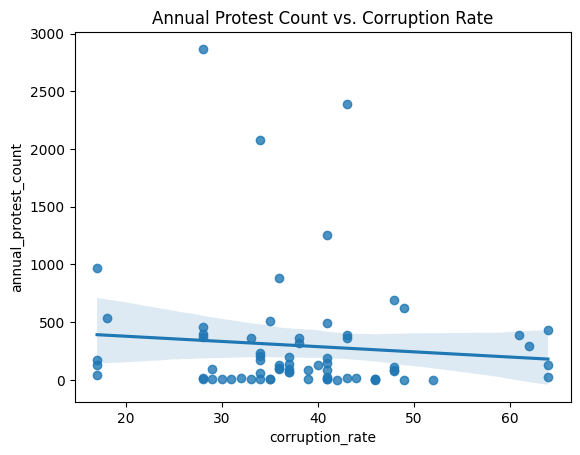


[correlation coefficient] protest number vs. unemployment_rate: r = -0.123, p-value = 3.098e-01
=== annual_protest_count ~ unemployment_rate 回归结果 ===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.015
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.047
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.310
Time:                          06:17:57   Log-Likelihood:                -536.89
No. Observations:                    70   AIC:                             1078.
Df Residuals:                        68   BIC:                             1082.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err

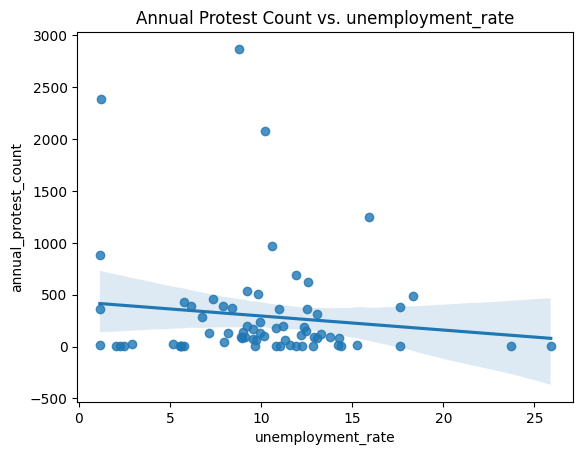


[correlation coefficient] protest number vs. HDI: r = 0.169, p-value = 1.616e-01
=== annual_protest_count ~ HDI 回归结果 ===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.029
Model:                              OLS   Adj. R-squared:                  0.014
Method:                   Least Squares   F-statistic:                     2.002
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.162
Time:                          06:17:57   Log-Likelihood:                -536.41
No. Observations:                    70   AIC:                             1077.
Df Residuals:                        68   BIC:                             1081.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

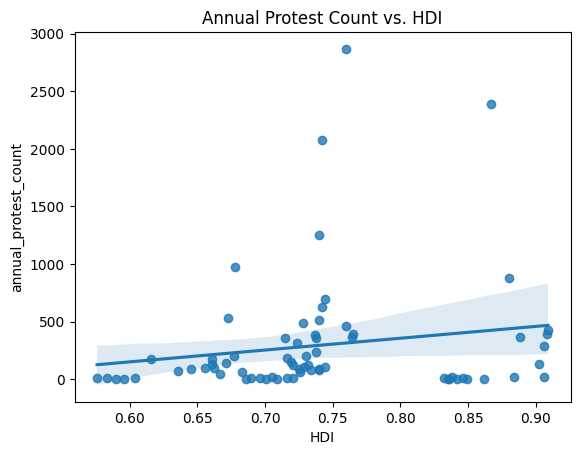


[correlation coefficient] protest number vs. FDI: r = -0.083, p-value = 4.952e-01
=== annual_protest_count ~ FDI 回归结果 ===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                 -0.008
Method:                   Least Squares   F-statistic:                    0.4704
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.495
Time:                          06:17:58   Log-Likelihood:                -537.18
No. Observations:                    70   AIC:                             1078.
Df Residuals:                        68   BIC:                             1083.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

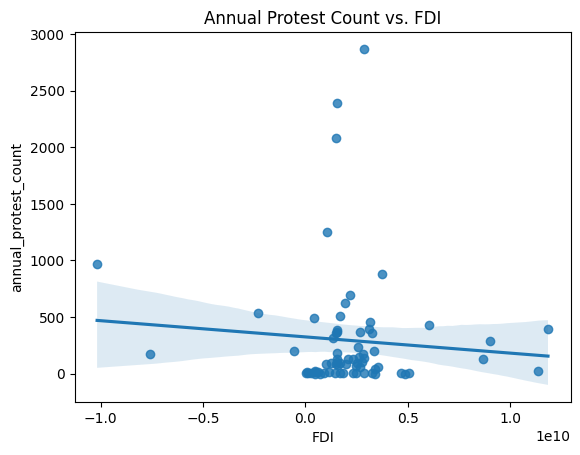


[correlation coefficient] protest number vs. GDP_per_capita: r = -0.050, p-value = 6.801e-01
=== annual_protest_count ~ GDP_per_capita 回归结果 ===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.003
Model:                              OLS   Adj. R-squared:                 -0.012
Method:                   Least Squares   F-statistic:                    0.1715
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.680
Time:                          06:17:58   Log-Likelihood:                -537.34
No. Observations:                    70   AIC:                             1079.
Df Residuals:                        68   BIC:                             1083.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err         

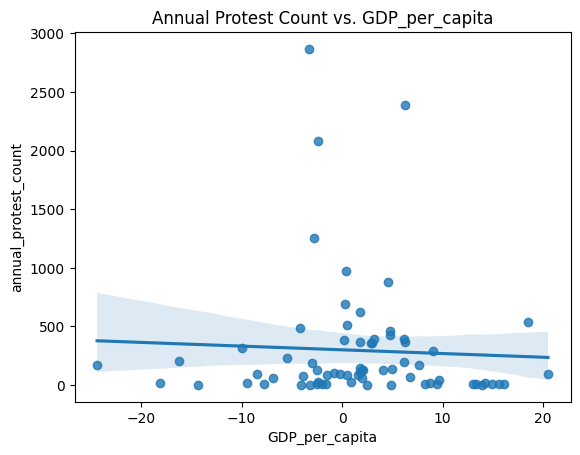


[correlation coefficient] protest number vs. Democracy_Index: r = 0.063, p-value = 6.022e-01
=== annual_protest_count ~ Democracy_Index 回归结果 ===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                 -0.011
Method:                   Least Squares   F-statistic:                    0.2742
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.602
Time:                          06:17:58   Log-Likelihood:                -537.28
No. Observations:                    70   AIC:                             1079.
Df Residuals:                        68   BIC:                             1083.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err       

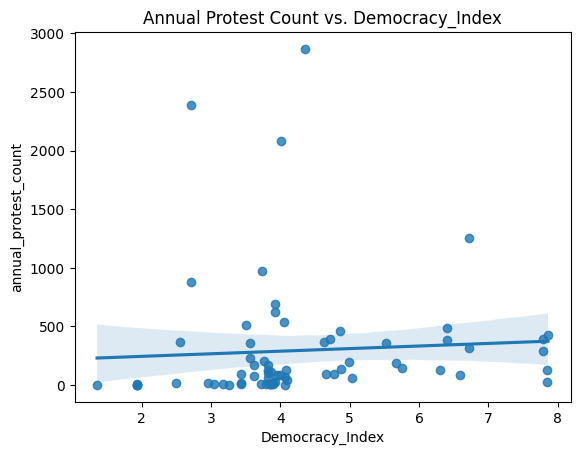


[correlation coefficient] protest number vs. Human_Right_Index: r = -0.001, p-value = 9.964e-01
=== annual_protest_count ~ Human_Right_Index 回归结果 ===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.015
Method:                   Least Squares   F-statistic:                 2.103e-05
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.996
Time:                          06:17:59   Log-Likelihood:                -537.42
No. Observations:                    70   AIC:                             1079.
Df Residuals:                        68   BIC:                             1083.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err

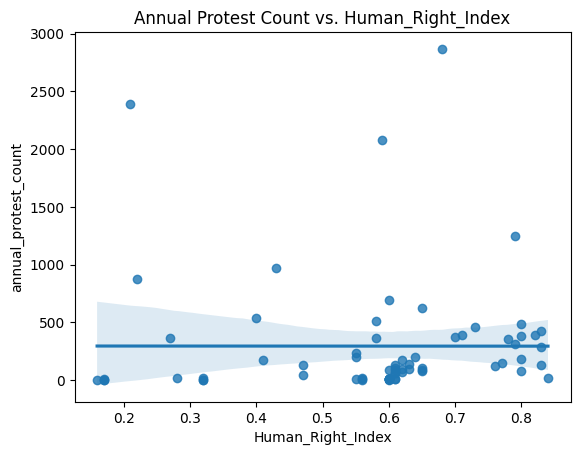


=== multiple regression: protest number ~ corruption rate + unemployment rate + HDI + FDI + GDP per capita + Democracy Index + Human Right Index===
                             OLS Regression Results                             
Dep. Variable:     annual_protest_count   R-squared:                       0.124
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     1.259
Date:                  Sat, 25 Jan 2025   Prob (F-statistic):              0.285
Time:                          06:17:59   Log-Likelihood:                -532.77
No. Observations:                    70   AIC:                             1082.
Df Residuals:                        62   BIC:                             1100.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                        coef    std err  

In [43]:


# 1. basic info
print("=== merged_df basic information ===")
print(merged_df.info())
print("\n===preview===")
print(merged_df.head())

# -------------------------------------------------------------------
# 2. correlation coefficient test： annual_protest_count and corruption_rate as examples
# -------------------------------------------------------------------
#
df_nonull = merged_df.dropna(subset=['annual_protest_count','corruption_rate'])
corr_coef, p_val = stats.pearsonr(df_nonull['annual_protest_count'], df_nonull['corruption_rate'])
print(f"\n[correlation coefficient] protest number vs. corruption rate: r = {corr_coef:.3f}, p-value = {p_val:.3e}")

# 3. OLS，corruption rate
model_corruption = smf.ols("annual_protest_count ~ corruption_rate", data=df_nonull).fit()
print("\n=== protest number ~ corruption rate OLS ===")
print(model_corruption.summary())

# 4. visualisation：scatter plot + regression line\
sns.regplot(x='corruption_rate', y='annual_protest_count', data=df_nonull)
plt.title('Annual Protest Count vs. Corruption Rate')
plt.show()

# -------------------------------------------------------------------
# 5. test the rest of indicators：unemployment rate, HDI, FDI, GDP, Dem, HRI ...
# -------------------------------------------------------------------

variables = ['unemployment_rate', 'HDI', 'FDI', 'GDP_per_capita', 'Democracy_Index', 'Human_Right_Index']
for var in variables:
    df_sub = merged_df.dropna(subset=['annual_protest_count', var])

    # (a) Pearson corelation index
    r, p = stats.pearsonr(df_sub['annual_protest_count'], df_sub[var])
    print(f"\n[correlation coefficient] protest number vs. {var}: r = {r:.3f}, p-value = {p:.3e}")

    # (b) OLS
    formula = f"annual_protest_count ~ {var}"
    model = smf.ols(formula, data=df_sub).fit()
    print(f"=== {formula} 回归结果 ===")
    print(model.summary())

    # (c) visualisation
    sns.regplot(x=var, y='annual_protest_count', data=df_sub)
    plt.title(f'Annual Protest Count vs. {var}')
    plt.show()

# -------------------------------------------------------------------
# 6. muliple regression
# -------------------------------------------------------------------
#  annual_protest_count ~ corruption_rate + unemployment_rate + HDI + ...

df_multi = merged_df.dropna(subset=['annual_protest_count','corruption_rate','unemployment_rate','HDI','FDI', 'GDP_per_capita', 'Democracy_Index', 'Human_Right_Index'])
multi_model = smf.ols("annual_protest_count ~ corruption_rate + unemployment_rate + HDI + FDI + GDP_per_capita + Democracy_Index + Human_Right_Index", data=df_multi).fit()
print("\n=== multiple regression: protest number ~ corruption rate + unemployment rate + HDI + FDI + GDP per capita + Democracy Index + Human Right Index===")
print(multi_model.summary())

=== Correlation Matrix ===
                      annual_protest_count  corruption_rate  \
annual_protest_count              1.000000        -0.090119   
corruption_rate                  -0.090119         1.000000   
unemployment_rate                -0.123150        -0.234740   
HDI                               0.169119         0.620908   
FDI                              -0.082883         0.669221   
GDP_per_capita                   -0.050151        -0.062934   
Democracy_Index                   0.063370         0.371403   
Human_Right_Index                -0.000556         0.162655   

                      unemployment_rate       HDI       FDI  GDP_per_capita  \
annual_protest_count          -0.123150  0.169119 -0.082883       -0.050151   
corruption_rate               -0.234740  0.620908  0.669221       -0.062934   
unemployment_rate              1.000000 -0.557924 -0.329428        0.137507   
HDI                           -0.557924  1.000000  0.509057       -0.109518   
FDI       

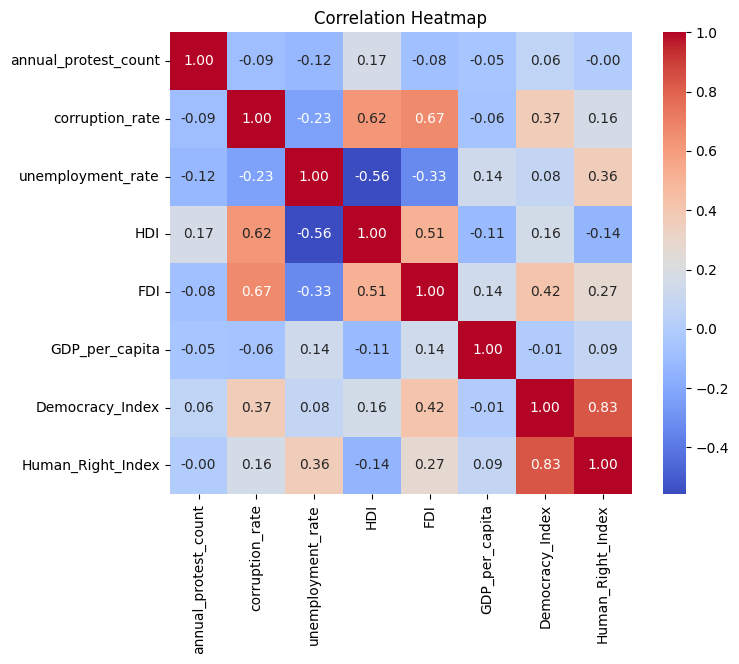

In [42]:

cols_of_interest = [
    'annual_protest_count',
    'corruption_rate',
    'unemployment_rate',
    'HDI',
    'FDI',
    'GDP_per_capita',
    'Democracy_Index',
    'Human_Right_Index'
]
df_corr = merged_df[cols_of_interest]


corr_matrix = df_corr.corr()


print("=== Correlation Matrix ===")
print(corr_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            square=True)
plt.title('Correlation Heatmap')
plt.show()
